In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import sklearn.linear_model as lm
import sklearn.preprocessing as pre
import sklearn.model_selection as ms
import matplotlib.pyplot as plt
import seaborn as sns

import harness

In [2]:
flights_train = harness.read_flights('../data/flights_train.csv')
flights_test = harness.read_flights('../data/flights_test.csv')

In [3]:
flights_clean = harness.clean_train(flights_train)

In [4]:
x_transform = harness.chain(
    [harness.keep_only, 'origin', 'dest'],
    [harness.transfer_grouped_means, flights_clean, 100, 'origin', 'dest'],
    harness.only_numeric,
    harness.scale,
)

In [5]:
transformer = harness.DataTransformer(x_transform)

In [6]:
x_train, y_train = transformer.extract_transform(flights_clean)

In [7]:
np.corrcoef(x_train.origin__dest_mean, y_train.arr_delay)[0, 1]

0.04237535569363868

In [8]:
y_train_has_mean = y_train[x_train.has_origin__dest_mean > 0]
x_train_has_mean = x_train[x_train.has_origin__dest_mean > 0]

In [9]:
np.corrcoef(x_train_has_mean.origin__dest_mean, y_train_has_mean.arr_delay)[0, 1]

0.13926936938372422

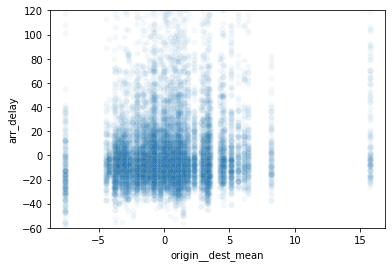

In [10]:
sns.scatterplot(
    data=x_train_has_mean.join(y_train_has_mean),
    x='origin__dest_mean', y='arr_delay', alpha=0.05
)
plt.ylim(-60, 120)
plt.show()

In [44]:
def train_model():
    linreg = lm.Ridge(random_state=42)
    grid_search = ms.GridSearchCV(
        linreg, dict(alpha=[10 ** i for i in range(-6, 7)]),
        n_jobs=-1
    )
    grid_search.fit(x_train_has_mean.values, y_train_has_mean.values)
    print(grid_search.best_score_)
    harness.save(grid_search.best_estimator_, 'od_pair_averages')

# def train_model():
#     linreg = lm.LinearRegression()
#     linreg.fit(x_train_has_mean.values, y_train_has_mean.values)
#     print(linreg.score(x_train_has_mean.values, y_train_has_mean.values))
#     harness.save(linreg, 'od_pair_averages')

In [45]:
train_model()

0.019118818101241986


In [46]:
linreg = harness.load('od_pair_averages')
linreg_model = harness.TrainedModel(linreg, transformer)

In [47]:
x_test, y_test, y_pred, score = linreg_model.validate(harness.clean_train(flights_test))

In [48]:
score

R squared: 0.000819
R squared (early = 0): -0.0307
R squared (only delay): -0.212

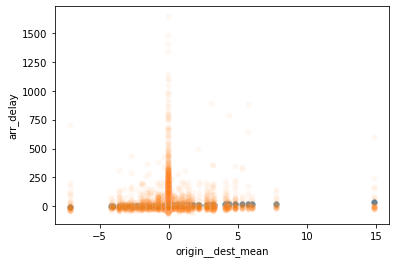

In [49]:
sns.scatterplot(data=x_test.join(y_pred), x='origin__dest_mean', y='arr_delay', alpha=0.05)
sns.scatterplot(data=x_test.join(y_test), x='origin__dest_mean', y='arr_delay', alpha=0.05)
plt.show()

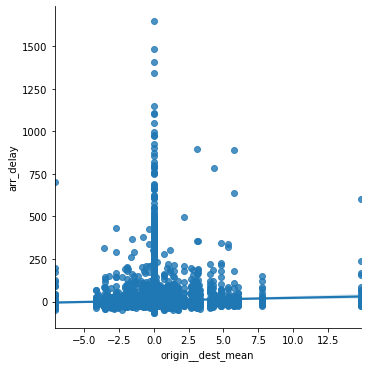

In [43]:
sns.lmplot(data=x_test.join(y_test), x='origin__dest_mean', y='arr_delay')

In [ ]:
# linreg_model.submit(
#     '../data/test.csv', 'od_pair_averages.csv', 'predicted_delay'
# )